# Chapter 14

## Load packages / modules

Standard library:
- Printf for string formatting
- Statistics for mean and std functions

External:
- CSV.jl to load CSV files
- DataFrames.jl for tabular data
- CategoricalArrays.jl for working with categorical data columns
- GLM.jl for models
- PyCall.jl for using the Python Statsmodels package
- CairoMakie.jl for plotting
- Roots.jl for finding a zero of a function

In [1]:
using Printf, Statistics
using CSV, DataFrames, CategoricalArrays, GLM, PyCall, CairoMakie, Roots

## Load data

In [2]:
nhefs_all = DataFrame(CSV.File("nhefs.csv"));

In [3]:
size(nhefs_all)

(1629, 64)

In [4]:
for s in [:education, :exercise, :active]
    nhefs_all[!, s] = categorical(nhefs_all[!, s])
end

Add a variable for censored weight

In [5]:
nhefs_all.censored = ismissing.(nhefs_all.wt82);

Subset the data as in the notebook for chapter 13

In [6]:
nhefs = dropmissing(nhefs_all, :wt82);

In [7]:
size(nhefs)

(1566, 65)

## Section 14.3

### Program 14.1

"In our smoking cessation example, we will use the nonstabilized IP weights $W^C = 1 \, / \, \Pr[C = 0|L,A]$ that we estimated in Chapter 12. Again we assume that the vector of variables $L$ is sufficient to adjust for both confounding and selection bias."  (pg 174)

We can reuse a function from chapter 12 to help us create IP weights

In [8]:
"""
    logit_ip_f(spec, data, y_name=:qsmk)

Create the f(y|X) part of IP weights from logistic regression

# Arguments
- `spec::FormulaTerm`: model formula
- `data::DataFrame`: data to fit model
- `y_name::Symbol`: name of outcome variable in `data` and `spec`

# Returns
- `Array`: IP weights

"""
function logit_ip_f(spec::FormulaTerm, data::DataFrame, y_name::Symbol = :qsmk)
    model = glm(spec, data, Binomial(), LogitLink())

    y_vals = data[!, y_name]
    pred_y = predict(model, data)
    pred_y0 = pred_y[y_vals .== 0]
    pred_y1 = pred_y[y_vals .== 1]

    weights = zeros(size(data, 1))
    weights[y_vals .== 1] = pred_y1
    weights[y_vals .== 0] = (1 .- pred_y0)
    weights
end;

In [9]:
spec = @formula(
    censored ~ sex
             + race
             + age + age ^ 2
             + education
             + smokeintensity + smokeintensity ^ 2
             + smokeyrs + smokeyrs ^ 2
             + exercise
             + active
             + wt71 + wt71 ^ 2
             + qsmk
)
weights = 1 ./ logit_ip_f(spec, nhefs_all, :censored);

In [10]:
ip_censor = weights[nhefs_all.censored .== 0];

In [11]:
println("   min     mean      max")
println("------------------------")
@printf "%6.2f   %6.2f   %6.2f" minimum(ip_censor) mean(ip_censor) maximum(ip_censor)

   min     mean      max
------------------------
  1.00     1.04     1.82

## Section 14.4

Still Program 14.1

"all individuals can be ranked according to the value of their observed outcome Y"

In [12]:
ranked = sort(nhefs, :wt82_71, rev=true);

In [13]:
ranked[1:2, [:seqn, :wt82_71]]

,seqn,wt82_71
,Int64,Float64?
1,23522,48.5384
2,6928,47.5113


In [14]:
ranked[end, [:seqn, :wt82_71]]

,seqn,wt82_71
,Int64,Float64?
1566,23321,-41.2805


## Section 14.5

### Program 14.2

"In our smoking cessation example, we first computed each individual’s value of the 31 candidates $H(2.0), H(2.1), H(2.2), \ldots , H(4.9)$ and $H(5.0)$ ..."

As in Chapter 12, we'll use the Python Statsmodels package for any model with clustering in covariance estimation, and we'll use GLM models where we might instead use GEE.

In [15]:
sm = pyimport("statsmodels.api");

To de-clutter, we'll silence a warning from Statsmodels

In [16]:
pywarn = pyimport("warnings")
pywarn.simplefilter("ignore");

Now we'll create a function that will perform the regression and return the info we need

The function returns a few different things we'll want from the regressions
1. absolute value of the coefficient (the basis of comparison),
2. the value of the coefficient
3. the value of psi that produced the coefficient, and
4. the p-value (for finding the 95% confidence interval)

In [17]:
"""
    logit_g_info(psi, data, y, X_cols, weights)

Return logistic regression parameters to identify best `psi`

Note: this is written specifically for the problem in this program,
and, for example, assumes the last column of `X_cols` is `:H_of_psi`.

# Arguments
- `psi::Float`
- `data::DataFrame`
- `y::Array`
- `X_cols::Array{String}`
- `weights::Array{Float}`

# Returns
- `NamedTuple` :
    - absolute value of H_of_psi coefficient
    - H_of_psi coefficient
    - psi value
    - p-value for H_of_psi coefficient

"""
function logit_g_info(psi, data, y, X_cols, weights)
    data.H_of_psi = data.wt82_71 .- psi .* data.qsmk
    X = Matrix(data[!, X_cols])
    groups = convert(Array{Int}, data.seqn)
    
    lgt = sm.GLM(y, X, freq_weights=weights, family=sm.families.Binomial())
    res = lgt.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups))

    alpha = res.params[end]
    pvalue = res.pvalues[end]
    return (abs_alpha=abs(alpha), alpha=alpha, psi=psi, pvalue=pvalue)
end;

For all uses here, `y` and the `X` columns are the same.

When passing `y` and `X` to Statsmodels, `nhefs` data will need
- a column of 1's
- categorical columns expanded into dummy encoding, and
- explicit squared columns

In [18]:
nhefs.constant = ones(nrow(nhefs));

In [19]:
X_cols = ["constant", "sex", "race"]

for column in ["education", "exercise", "active"]
    for (value_num, value) in enumerate(sort(unique(nhefs[!, column])))
        if value_num > 1
            newname = column * "_$value"
            transform!(nhefs, column => (x -> x .== value) => newname)
            push!(X_cols, newname)
        end
    end
end

for column in ["age", "smokeintensity", "smokeyrs", "wt71"]
    newname = column * "^2"
    transform!(nhefs, column => (x -> x .^ 2) => newname)
    push!(X_cols, column)
    push!(X_cols, newname)
end

push!(X_cols, "H_of_psi");

In [20]:
y = nhefs.qsmk;

We'll run the regression once for the known right answer

In [21]:
g_info = logit_g_info(3.446, nhefs, y, X_cols, ip_censor);

In [22]:
@printf "psi: %0.3f  regression coefficient: %0.2g" g_info.psi g_info.alpha

psi: 3.446  regression coefficient: -1.9e-06

Now we'll do the course-grained search for $\psi$ with $H(2.0), H(2.1), H(2.2), \ldots , H(4.9)$ and $H(5.0)$ (pg 178)

In [23]:
psi_vals = collect(2.0:0.1:5.0);

In [24]:
g_info = [
    logit_g_info(psi, nhefs, nhefs.qsmk, X_cols, ip_censor)
    for psi in psi_vals
];

In [25]:
# by default, `min` will minimize the first value,
# which in this case is the absolute value of the coefficient
best = minimum(g_info) ;

In [26]:
@printf "best psi: %0.4f  best alpha: %0.5f" best.psi best.alpha

best psi: 3.4000  best alpha: 0.00086

The plot below shows $p$-value as a function of $\psi$, with a red line at 0.05.

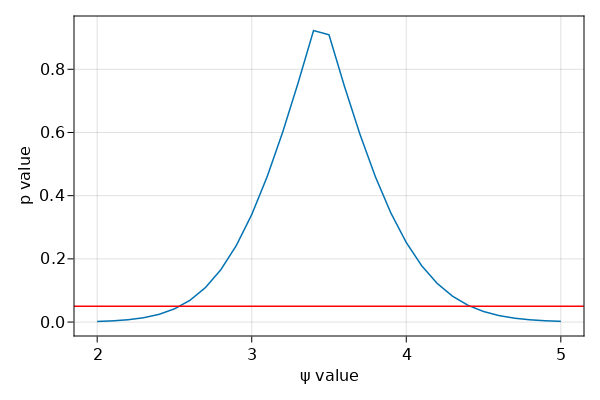

In [27]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="ψ value", ylabel="p value")

lines!(ax, psi_vals, [trial.pvalue for trial in g_info])
abline!(ax, 0.05, 0, color=:red)

fig

To find the 95% confidence interval, we find the last values that are below the line, coming from the left and the right.

In [28]:
cutoff = 0.05
ci_lo = maximum([g.psi for g in g_info[1:length(g_info)÷2] if g.pvalue < cutoff])
ci_hi = minimum([g.psi for g in g_info[length(g_info)÷2:end] if g.pvalue < cutoff])

@printf "95%% confidence interval: (%0.2f, %0.2f)" ci_lo ci_hi

95% confidence interval: (2.50, 4.50)

We can run a finer search between 3.4 and 3.5, with steps of 0.001. That can be done using the same steps as above, but using

```julia
psi_vals = collect(3.4:0.001:3.5)
```

Instead, we'll use automatic function optimization to find a more exact $\psi$.

In [29]:
function abs_alpha(psi)
    g_info = logit_g_info(psi, nhefs, nhefs.qsmk, X_cols, ip_censor)
    return g_info.abs_alpha
end;

In [30]:
find_zero(abs_alpha, 4.0)

3.445898804229873

The output is the estimated $\psi$, which rounds to 3.446, as expected.

## Section 14.6

### Program 14.3

We can solve for $\psi$ directly. From Technical Point 14.2, in the one-parameter case we have

$$
\hat\psi = \frac{
    \sum_{i=1}^{N} W_i^C Y_i\left( A_i - \mathrm{E}[A|L_i]\right)
}{
    \sum_{i=1}^{N} W_i^C A_i\left( A_i - \mathrm{E}[A|L_i]\right)
},
$$

where the sum is over the uncensored observations, $W^C$ is the IP weights, $Y$ is `wt82_71`, $A$ is `qsmk`, and $\mathrm{E}[A|L_i]$ is the predicted `qsmk` from the model below.

In [31]:
spec = @formula(
    qsmk ~ sex
         + race
         + age + age ^ 2
         + education
         + smokeintensity + smokeintensity ^ 2
         + smokeyrs + smokeyrs ^ 2
         + exercise
         + active
         + wt71 + wt71 ^ 2
)
model = glm(spec, nhefs, Binomial(), LogitLink(), wts=ip_censor)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

qsmk ~ 1 + sex + race + age + :(age ^ 2) + education + smokeintensity + :(smokeintensity ^ 2) + smokeyrs + :(smokeyrs ^ 2) + exercise + active + wt71 + :(wt71 ^ 2)

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                           Coef.   Std. Error      z  Pr(>|z|)     Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -2.40295      1.31356      -1.83    0.0673  -4.97748       0.171585
sex                 -0.513729     0.150072     -3.42    0.0006  -0.807865     -0.219594
race                -0.86089      0.205875     -4.18    <1e-04  -1.2644       -0.457382
age                  0.115158     0.0494576     2.33    0.0199   0.0182

Using the equation at the top of this section, $\hat{\psi}$ is calculated as below

In [32]:
A = nhefs.qsmk
A_pred = predict(model, nhefs)
Y = nhefs.wt82_71

estimate = (
    sum(ip_censor .* Y .* (A .- A_pred)) /
    sum(ip_censor .* A .* (A .- A_pred))
)

3.4458972305360316

Now a multi-parameter example

"If $\psi$ is D-dimensional..." (Technical Point 14.2).

"For example, suppose we believe that the average causal effect of smoking cessation depends on the baseline level os smoking intensity $V$" (pg 180).

The following is a direct translation of what's in the R and Stata code examples

In [33]:
diff = A .- A_pred
diff2 = ip_censor .* diff;

In [34]:
lhs = [
    sum(A .* diff2),
    sum(A .* nhefs.smokeintensity .* diff2),
    sum(A .* nhefs.smokeintensity .* diff2),
    sum(A .* nhefs.smokeintensity.^2 .* diff2)
]

lhs = reshape(lhs, 2, 2)

2×2 Matrix{Float64}:
  292.076  5701.55
 5701.55      1.53045e5

In [35]:
rhs = [
    sum(Y .* diff2) 
    sum(Y .* nhefs.smokeintensity .* diff2)
]

2-element Vector{Float64}:
  1006.4643890774512
 20901.0547394765

In [36]:
psi = inv(lhs) * rhs

2-element Vector{Float64}:
 2.85946930675507
 0.030041257476582983